In [1]:
import numpy as np
import pandas as pd
import email
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from email.parser import BytesParser
from email.policy import default
import csv
import os
import pathlib
import pprint
from os.path import dirname, abspath


In [2]:
# d = dirname(dirname(abspath('__file__')))

In [4]:
#location = f"{d}/case study 3/"

In [31]:
# emails = {"index":[]}
# for path, subdirectories, filelist in os.walk(os.path.join(d,"SpamAssassinMessages")):
#     for f in filelist:
        
#         label = 0 if "ham" in path.lower() else 1
#         with open(os.path.join(path, f), "rb") as fp:
#             msg = BytesParser(policy=default).parse(fp)
#             with open(os.path.join(path, f), "r",encoding= 'utf-8', errors='ignore') as new_f:
#                 msg = email.message_from_file(new_f)
#                 for part in msg.walk():
#                     if part.get_content_type() == 'text/plain':
#                         body = part.get_payload()  # decode
#                 emails["index"].append({
#                     "Subject": msg.get("Subject"),
#                     "From": msg.get("from"),
#                     "Body": body,
#                     "isSpam": label,
#                     "FileID": f
#                 })

# df = pd.DataFrame.from_dict(emails["index"])

b'<HTML><HEAD><TITLE>Backup your DVD\'s</TITLE>\n<META http-equiv=Content-Type content="text/html; charset=iso-8859-1">\n<META content="MSHTML 6.00.2600.0" name=GENERATOR></HEAD>\n\n\n<DIV></DIV>\n<BLOCKQUOTE \nstyle="PADDING-RIGHT: 0px; PADDING-LEFT: 5px; MARGIN-LEFT: 5px; BORDER-LEFT: #000000 2px solid; MARGIN-RIGHT: 0px">\n  <DIV></DIV>\n  <TABLE cellSpacing=0 cellPadding=0 width=525 align=center bgColor=#ffffff \n  border=0>\n\n    <TBODY> \n    <TR> \n      <TD width="33"><IMG height=1 src="images/spacer.gif" width=33 border=0></TD>\n      <TD width="174"><IMG height=1 src="images/spacer.gif" width=174 border=0></TD>\n      <TD width="360"><IMG height=1 src="images/spacer.gif" width=360 border=0></TD>\n      <TD width="33"><IMG height=1 src="images/spacer.gif" width=33 border=0></TD>\n    </TR>\n    <TR> \n      <TD colSpan=4><a href="http://www.terra.es/personal9/iop1008/"><IMG height=253 src="http://www.terra.es/personal9/iop1008/images/mailer8_r1_c1.gif" \n        width=600 use

b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<html>\n<head>\n<title>Welcome</title>\n</head>\n<body>\n<center>\n<a href="http://home.attbi.com/~johnsonhomestor1/pro.htm"><img src="http://johnson2276.itctv.com/j/johnson2276/Images/IntroDuction.jpg" alt="Welcome"><br><font color="#6633ff"><b><small><small><br>Click on to continue</a></font></small></small><br>\n</center>\n\n</body>\n</html>\n'
b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n<HTML><HEAD><TITLE>EM049</TITLE>\n</HEAD>\n<BODY bgColor="#FFFFFF" leftMargin="0" topMargin="0" MARGINHEIGHT="0" MARGINWIDTH="0">\n<table width="550" border="0" cellspacing="0" cellpadding="0" align="center">\n  <TBODY>\n  <TR>\n    <TD colSpan=2><A href="http://theadmanager.com/server/c.asp?ad_key=FWOATHSKUDMM&ext=1">\n\t<IMG src="http://admanmail.com/ads/adman/kmart/EM049_01.gif" alt="" border="0" height="59" width="550"></A></TD></TR>\n  <TR>\n    <TD><A href="http://theadmanager.com/server/c.asp?ad_key=FWOA

b'<html>\n\n<head>\n<meta http-equiv="Content-Language" content="en-us">\n<meta name="GENERATOR" content="Microsoft FrontPage 4.0">\n<meta name="ProgId" content="FrontPage.Editor.Document">\n<meta http-equiv="Content-Type" content="text/html; charset=windows-1252">\n<title>Norton AD</title>\n</head>\n\n<body>\n\n<table border="0" width="489" height="54" bgcolor="#FFFFFF">\n  <tr>\n    <td width="100%" height="48" bgcolor="#FFFFFF" align="center"><font face="Impact" color="#CC0000" size="3">Take\n      Control of Your Computer With This Top-of-the-Line Software!</font></td>\n  </tr>\n</table>\n\n<table border="5" cellspacing="3" width="489" cellpadding="3" bgcolor="#990033"  bordercolor="#FFFFFF" style="border-collapse: collapse" bordercolordark="#000000" height="567" bordercolorlight="#FFFF99">\n  <tr>\n    <td width="467" height="555" bordercolorlight="#FFFFFF" bordercolordark="#FFFF99">\n      <table border="6" width="100%" height="86" bgcolor="#FFFF99" bordercolor="#FFFFFF">\n      

LookupError: unknown encoding: default

In [5]:
# df.to_csv("spam_train.csv", index=False)

In [2]:
df = pd.read_csv("spam_train.csv")

In [3]:
df["isSpam"].value_counts()

0    6954
1    2400
Name: isSpam, dtype: int64

In [4]:
df.isnull().sum()

Subject    26
From        7
Body        8
isSpam      0
FileID      0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
df

,Subject,From,Body,isSpam,FileID
0,Let us find the right mortgage lender for you ...,pamela4701@eudoramail.com,"Dear Homeowner,\n \nInterest Rates are at thei...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,"Friend, Copy ANY DVD or Playstation Game with ...",CopyYourDVD <atomica2020@hotmail.com>,"Friend,Now you can copy DVD's and Games\nhttp:...",1,0355.94ebf637e4bd3db8a81c8ce68ecf681d
2,5% Guaranteed for Eight Years,"""IQ - Safe Harbor"" <sh@insiq.us>",Pocket the newest 8 year annuity!\t Pocket th...,1,0395.bb934e8b4c39d5eab38f828a26f760b4
3,Congratulations! You Get a Free Handheld Organ...,Customer Service <greatoffers@sendgreatoffers....,Pocket the newest 8 year annuity!\t Pocket th...,1,0485.9021367278833179285091e5201f5854
4,PROTECT YOUR INFORMATION AND YOUR COMPUTER,"""don"" <apf@wu-wien.ac.at>",ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
...,...,...,...,...,...
9315,RE: [Razor-users] What's wrong with the Razor ...,"""Rose, Bobby"" <brose@med.wayne.edu>","I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
9316,Re: W3C approves HTML 4 'emotitags' [...],harley@argote.ch (Robert Harley),Damien Morton quoted:\n>W3C approves HTML 4 'e...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
9317,Re: Ximian apt repos?,Mark Derricutt <mark@talios.com>,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n> t...",0,01127.841233b48eceb74a825417d8d918abf8
9318,Re: Installing RPM,Matthias Saou <matthias@egwn.net>,"Once upon a time, Manfred wrote :\n\n> I would...",0,01178.5c977dff972cd6eef64d4173b90307f0


In [10]:
df["isSpam"].value_counts()

0    6941
1    2379
Name: isSpam, dtype: int64

Build a spam classifier using naive Bayes and clustering. You will have to create your own dataset from the input messages. Be sure to document how you created your dataset.

In [11]:
#remove new lines and such
df = df.replace(r'\n',' ', regex=True)
df = df.replace(r'\t',' ', regex=True)
df = df.replace(r'b\'',' ', regex=True)
df = df.replace(r'b\"',' ', regex=True)


In [12]:
df

,Subject,From,Body,isSpam,FileID
0,Let us find the right mortgage lender for you ...,pamela4701@eudoramail.com,"Dear Homeowner, Interest Rates are at their ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,"Friend, Copy ANY DVD or Playstation Game with ...",CopyYourDVD <atomica2020@hotmail.com>,"Friend,Now you can copy DVD's and Games http:/...",1,0355.94ebf637e4bd3db8a81c8ce68ecf681d
2,5% Guaranteed for Eight Years,"""IQ - Safe Harbor"" <sh@insiq.us>",Pocket the newest 8 year annuity! Pocket the...,1,0395.bb934e8b4c39d5eab38f828a26f760b4
3,Congratulations! You Get a Free Handheld Organ...,Customer Service <greatoffers@sendgreatoffers....,Pocket the newest 8 year annuity! Pocket the...,1,0485.9021367278833179285091e5201f5854
4,PROTECT YOUR INFORMATION AND YOUR COMPUTER,"""don"" <apf@wu-wien.ac.at>",ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
...,...,...,...,...,...
9315,RE: [Razor-users] What's wrong with the Razor ...,"""Rose, Bobby"" <brose@med.wayne.edu>","I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
9316,Re: W3C approves HTML 4 'emotitags' [...],harley@argote.ch (Robert Harley),Damien Morton quoted: >W3C approves HTML 4 'em...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
9317,Re: Ximian apt repos?,Mark Derricutt <mark@talios.com>,"On Mon, 2002-07-22 at 06:50, che wrote: > tha...",0,01127.841233b48eceb74a825417d8d918abf8
9318,Re: Installing RPM,Matthias Saou <matthias@egwn.net>,"Once upon a time, Manfred wrote : > I would l...",0,01178.5c977dff972cd6eef64d4173b90307f0


In [20]:
pd.set_option('display.max_colwidth', None)

In [13]:
df = df.replace(r'<',' ', regex=True)
df = df.replace(r'>',' ', regex=True)

In [14]:
df["Body"] = df['Body'].str.lower()

In [15]:
df["Subject"] = df['Subject'].str.lower()

In [16]:
df["From"] = df['From'].str.lower()

In [17]:
X = df.drop(["isSpam","FileID"], axis=1).copy()

In [18]:
X["Email"] = X["Subject"] +" "+ X["From"] +" "+ X["Body"]

In [19]:
X = X.drop(columns=["Body","From","Subject"], axis=1)

In [20]:
X.reset_index(inplace=True,drop=True)

In [21]:
y = df["isSpam"].values

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

c_vect = CountVectorizer(stop_words="english")
X= c_vect.fit_transform(X["Email"])

# tfidf = TfidfVectorizer()

In [24]:
df_X = pd.DataFrame(X.todense(), columns = c_vect.get_feature_names())

/Users/satvikajmera/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
df_X

,00,000,0000,00000,000000,00000000,000000000,00000002,00000004,0000001,...,帳θ,汾ϵйэաκⱥʱʮ,磺塢չ塢,隊x,죺ʹҵʾչ,줽ǥx,쵥λ,ﵽvawry,𬣡b,𬣤jӡa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9315,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9318,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Baseline test for Naive Bayes with No Clustering

In [27]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
import time

skf = StratifiedKFold(random_state=42, n_splits=5,shuffle=True)
nb = MultinomialNB()

acc_scores = []

iter_num=0

for train_indices, test_indices in skf.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    nb.fit(X_train,y_train)  # train object

    y_hat = nb.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    acc_scores.append(acc)
    print('Accuracy:', acc)
    iter_num+=1

====Iteration 0  ====
Accuracy: 0.990343347639485
====Iteration 1  ====
Accuracy: 0.9951716738197425
====Iteration 2  ====
Accuracy: 0.9930257510729614
====Iteration 3  ====
Accuracy: 0.9908798283261803
====Iteration 4  ====
Accuracy: 0.9865879828326181
CPU times: user 52 ms, sys: 14.7 ms, total: 66.7 ms
Wall time: 67.8 ms


In [28]:
import matplotlib.pyplot as plt

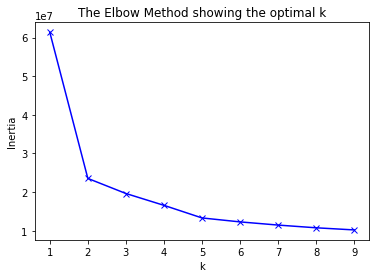

In [29]:
from sklearn.cluster import KMeans
# k means determine k
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    inertia.append(kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()